In [17]:
import pandas as pd
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'

#Data loading
df = pd.read_csv("resultFiles/Ranksum.CD8.gene.csv", engine='c', index_col=0)
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')
longDD_samples, shortDD_samples = exttoolkit.get_sample_name_by_contValues(meta_data, 'HCVB_ID', 'DiseaseDuration', 50)

longDD_samples = list(set(longDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
shortDD_samples = list(set(shortDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
df = df[longDD_samples+shortDD_samples].dropna() # reform df with intersected samples

/Users/junheeyun/OpenKBC/multiple_sclerosis_proj/notebook/notebook_utils/OpenKbcMSToolkit.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_df[dataColname] = cont_df[dataColname].astype(float) # make float


In [18]:
X = df.T.values # Training sample
y = [0]*len(longDD_samples)+[1]*len(shortDD_samples) # Training y
X.shape

(132, 91)

Optimal number of features : 62


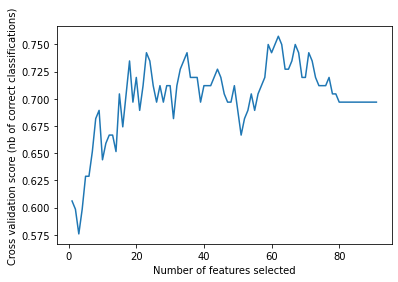

In [19]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

## Reference: 
## https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

estimator = SVC(kernel="linear") # linear
min_features_to_select = 1
rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(2),\
    scoring='accuracy', min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [20]:
import numpy as np
print("RFECV features: ")
len(df.index[np.where(rfecv.ranking_==1)]) # Top1

RFECV features: 


62

In [21]:
df.loc[df.index[np.where(rfecv.ranking_==1)]].to_csv('resultFiles/Ranksum.RFECV.CD8.gene.csv')